# Loading GHN-3 and Predicting Parameters for all PyTorch ImageNet models 

## Paper: Can We Scale Transformers to Predict Parameters of Diverse ImageNet Models?  https://arxiv.org/abs/2303.04143

Authors: Boris Knyazev, Doha Hwang, Simon Lacoste-Julien

## 1. Install ppuda (optional, if not installed yet)

In [ ]:
!pip install git+https://github.com/facebookresearch/ppuda.git
!pip show ppuda

In [1]:
# Import required modules
import inspect
import types
import time
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import joblib
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from ghn3 import from_pretrained, Graph, GraphBatch


print('torch', torch.__version__)
print('torchvision', torchvision.__version__)
print('Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly')

torch 1.12.1+cpu
torchvision 0.13.1+cpu
Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly


## 2. Load GHN-3

As the largest and best performing GHN-3 model (`ghn3xlm16`) takes about 2.5GB, it takes a while to download the model.

The model is downloaded from HuggingFace: https://huggingface.co/SamsungSAILMontreal/ghn3/tree/main.

We made four GHN-3 variants from our paper available: `ghn3tm8, ghn3sm8, ghn3lm8, ghn3xlm16`.

In [2]:
ghn = from_pretrained('ghn3xlm16.pt')  # one of 'ghn3tm8.pt', 'ghn3sm8.pt', 'ghn3lm8.pt', 'ghn3xlm16.pt' (default)

loading GHN-3 with 654365184 parameters is done!


## 3. Predict parameters for ResNet-50 and compare to the downloaded ResNet-50 for sanity check

fine_tuning: True
Parameter prediction for ResNet-50 done in 2.852 seconds on cpu


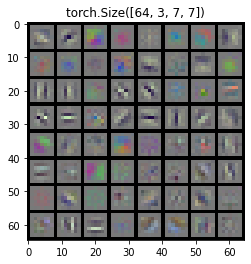

Sanity check on ResNet-50 is done!


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

fine_tuning = True  # true if predicted parameters will be fined or false for direct evaluation of predicted parameters
print('fine_tuning:', fine_tuning)

model = models.resnet50()
graph = Graph(model)
# graph.visualize()  # to visualize ResNet-50 graph
start = time.time()
model = ghn(model, GraphBatch([graph]).to_device(device), bn_train=not fine_tuning)
print('Parameter prediction for ResNet-50 done in %.3f seconds on %s' % (time.time() - start, device))

weights = model.conv1.weight.data.cpu()
grid = torchvision.utils.make_grid(weights, nrow=8, normalize=True, padding=1)
plt.figure(figsize=(4, 4))
plt.title(weights.shape)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

model_sanity_check = models.resnet50()
model_sanity_check.load_state_dict(joblib.load(hf_hub_download(repo_id='SamsungSAILMontreal/ghn3',
                                                               filename='resnet50_ghn3xlm16_init.pt'))['state_dict'])

dict1 = dict(model.named_parameters())
for n, p in model_sanity_check.named_parameters():
    if not torch.allclose(p, dict1[n], atol=1e-6):
        print('warning: big discrepancy {:.3e} for param: {}'.format(torch.norm(p - dict1[n]), n))        

print('Sanity check on ResNet-50 is done!')        

## 4. Predict parameters for all PyTorch models

In [4]:
with open('ghn3/norms_ghn3xlm16.json', 'r') as f:
    norms = json.load(f)
    
# Enumerate all PyTorch models of ImageNet classification
# Should be >= 74 models in torchvision>=0.13.1
all_torch_models = []
for m in dir(models):
    if m[0].isupper() or m.startswith('_') or m.startswith('get') or \
      not inspect.isfunction(eval('models.%s' % m)):
        continue
    
    if m in ['vit_h_14', 'regnet_y_128gf']:
        print('=== %s was not included in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===' 
              % m.upper())
        continue  # skip for consistency with the paper
        
    all_torch_models.append(m)
    
print('\n%d PyTorch models found. Predicting parameters for all...' % len(all_torch_models))    

fine_tuning = True  # true if predicted parameters will be fined or false for direct evaluation of predicted parameters
start_all = time.time()
norms_matched = []
for m_ind, m in enumerate(all_torch_models):
    kw_args = {'init_weights': False} if m in ['googlenet', 'inception_v3'] else {}

    # Predict parameters
    model = eval(f'models.{m}(**kw_args)')
    n_params = sum([p.numel() for p in model.parameters()]) / 10**6
    if m == 'inception_v3':
        model.expected_input_sz = 299
    print('{}/{}: {} with {:.2f}M parameters'.format(m_ind + 1,
                                                     len(all_torch_models),
                                                     m.upper(), 
                                                     n_params), end='...')
    start = time.time()
    model = ghn(model, GraphBatch([Graph(model)]).to_device(device), bn_train=not fine_tuning)
    
    total_norm = torch.norm(torch.stack([p.norm() for p in model.parameters()]), 2)
    norms_matched.append(abs(norms[m] - total_norm.item()) < 1e-2)
    print('done in {:.2f} seconds, total param norm={:.4f} ({})'.
          format(time.time() - start,
                 total_norm.item(),
                 'norms matched' if norms_matched[-1] else ('ERROR: norm not matched with %.2f' % norms[m])))
        
    # "WARNING: number of predicted ..." means that some layers in the model are not supported by the GHN
    # unsupported modules are initialized using built-in PyTorch methods

print('\ndone for {} models in {:.2f} seconds, norms matched for {} models'.format(len(norms_matched), 
                                                                                   time.time() - start_all,
                                                                                   sum(norms_matched)))


=== REGNET_Y_128GF was not included in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== VIT_H_14 was not included in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===

74 PyTorch models found. Predicting parameters for all...
1/74: ALEXNET with 61.10M parameters...done in 2.06 seconds, total param norm=72.4766 (norms matched)
2/74: CONVNEXT_BASE with 88.59M parameters...WARNING: number of predicted (88573416) or actual (88591464) parameters must match
done in 26.43 seconds, total param norm=355.1909 (norms matched)
3/74: CONVNEXT_LARGE with 197.77M parameters...WARNING: number of predicted (197740264) or actual (197767336) parameters must match
done in 26.50 seconds, total param norm=399.8319 (norms matched)
4/74: CONVNEXT_SMALL with 50.22M parameters...WARNING: number of predicted (50210152) or actual (50223688) parameters must match
done in 26.08 seconds, total param norm=286.9353 (norms matched)
5/74: CONVNEXT_TINY with 

64/74: VGG13_BN with 133.05M parameters...done in 1.65 seconds, total param norm=66.5945 (norms matched)
65/74: VGG16 with 138.36M parameters...done in 2.35 seconds, total param norm=62.9869 (norms matched)
66/74: VGG16_BN with 138.37M parameters...done in 2.42 seconds, total param norm=75.7611 (norms matched)
67/74: VGG19 with 143.67M parameters...done in 4.12 seconds, total param norm=64.5850 (norms matched)
68/74: VGG19_BN with 143.68M parameters...done in 3.14 seconds, total param norm=73.9692 (norms matched)
69/74: VIT_B_16 with 86.57M parameters...WARNING: setting a 4d size (1, 768, 14, 14) instead of 3d (1, 197, 768)
done in 4.86 seconds, total param norm=366.0770 (norms matched)
70/74: VIT_B_32 with 88.22M parameters...WARNING: setting a 4d size (1, 768, 7, 7) instead of 3d (1, 50, 768)
done in 3.52 seconds, total param norm=358.9109 (norms matched)
71/74: VIT_L_16 with 304.33M parameters...WARNING: setting a 4d size (1, 1024, 14, 14) instead of 3d (1, 197, 1024)
done in 12.45 